In [1]:
import argparse
import midi
import os

from constants import *
from dataset import load_all
from generate import write_file, generate
from play_music_util import play_music

import pygame
import base64

from playsound import playsound
import numpy as np

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [13]:
import math
import time
from IPython import display
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import optim
%matplotlib inline

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch

In [5]:
# styles[0] = 'data/test'
styles[0]

['data/test']

In [6]:
print('Loading data')
train_data, train_labels = load_all(styles, BATCH_SIZE, SEQ_LEN)

Loading data


In [130]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from constants import *
import numpy as np

import math
import time
from IPython import display
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import optim

criterion_bce_play = nn.BCELoss()  
criterion_bce_replay = nn.BCELoss() 
criterion_mse = nn.MSELoss()  

def compute_loss(y_pred, y_true):
    
    played = y_true[:, :, :, 0]
    
    bce_note = criterion_bce_play(y_pred[:, :, :, 0], y_true[:, :, :, 0])

    replay = played*y_pred[:, :, :, 1] + (1 - played)*y_true[:, :, :, 1]
    
    bce_replay = criterion_bce_replay(replay, y_true[:, :, :, 1])
    
    volume = played*y_pred[:, :, :, 2] + (1 - played)*y_true[:, :, :, 2]
    mse = criterion_mse(volume, y_true[:, :, :, 2] )
    
    return bce_note + bce_replay + mse


def iterate_minibatches(train_data, train_labels, batchsize):
    indices = np.random.permutation(np.arange(len(train_labels)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        
        if cuda:      
            yield  Variable(torch.FloatTensor(train_data[ix])).cuda(), Variable(torch.FloatTensor(train_labels[ix])).cuda()
        else:
            yield Variable(torch.FloatTensor(train_data[ix])), Variable(torch.FloatTensor(train_labels[ix]))
            
class time_axis(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__() 
        self.n_layers = 1
        self.hidden_size = TIME_AXIS_UNITS
        self.input_size = NOTE_UNITS
        

        self.time_lstm = nn.LSTM(self.input_size, self.hidden_size, self.n_layers, dropout=0.1, 
                                 batch_first=True, )
        self.dropout = nn.Dropout(p=0.2, inplace=True)
        
    def forward(self, notes):
        
        """
        arg:
            notes - (batch, time_seq, note_seq, note_features)
        
        out: 
            (batch, time_seq, note_seq, hidden_features)
            
        """
        initial_shape = notes.shape
        
        notes = notes.permute(0, 2, 1, 3).contiguous()
        notes = notes.view((-1,)+ notes.shape[-2:]).contiguous()
            
        out, hidden = self.time_lstm(notes) 
                
        time_output = out.contiguous().view((initial_shape[0],) + (initial_shape[2],) + out.shape[-2:])
        time_output = time_output.permute(0, 2, 1, 3)
#         self.dropout(time_output)
        
        return time_output        
    
class note_axis(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()   
        
        self.n_layers = 2
        self.hidden_size = NOTE_AXIS_UNITS
        # number of time features plus number of previous higher note in the same time momemt
        self.input_size = TIME_AXIS_UNITS + NOTE_UNITS
        
        # maybe it is better to make two lstm and make the second one bideractional 
        self.note_lstm = nn.LSTM(self.input_size, self.hidden_size, self.n_layers, dropout=0.1, 
                                 batch_first=True, )
        
        self.dropout = nn.Dropout(p=0.2, inplace=True)
        
        self.logits = nn.Linear(self.hidden_size, NOTE_UNITS) 
        
    def forward(self, notes, chosen):
        """
        arg:
            notes - (batch, time_seq, note_seq, time_hidden_features)
        
        out: 
            (batch, time_seq, note_seq, next_notes_features)
            
        """
                
        # Shift target one note to the left.
        shift_chosen = nn.ZeroPad2d((0, 0, 1, 0))(chosen[:, :, :-1, :])            
        note_input = torch.cat([notes, shift_chosen], dim=-1)
        
        initial_shape = note_input.shape
        
        note_input = note_input.contiguous().view((-1,)+ note_input.shape[-2:]).contiguous()
        
        out, hidden = self.note_lstm(note_input) 
        
        note_output = out.contiguous().view(initial_shape[:2] + out.shape[-2:])

#         self.dropout(note_output)

        logits = self.logits(note_output) 
        next_notes = nn.Sigmoid()(logits)
        
        return next_notes 
    
class Generator(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()        
        
        self.time_ax = time_axis() 
        self.note_ax = note_axis()
        
    def forward(self, notes, chosen):
        
        note_ax_output = self.time_ax(notes)
        output = self.note_ax(note_ax_output, chosen)
        
        return output   
    
def train(generator, X_tr, X_te, y_tr, y_te, batchsize=3, n_epochs = 3):
    
    optimizer = optim.Adam(generator.parameters())
    n_train_batches = math.ceil(len(X_tr)/batchsize)
    n_validation_batches = math.ceil(len(X_te)/batchsize)

    epoch_history = {'train_loss':[], 'val_loss':[]}

    for epoch in range(n_epochs):

        start_time = time.time()

        train_loss = 0
        generator.train(True)    
        for X, y in tqdm(iterate_minibatches(X_tr, y_tr, batchsize)):

            optimizer.zero_grad()

            pred = generator(X, y)
            loss = compute_loss(pred, y)        
            loss.backward()

            optimizer.step()

            train_loss += loss.cpu().data.numpy()[0]

        train_loss /= n_train_batches
        epoch_history['train_loss'].append(train_loss)
    #     print('train_loss', train_loss)

        generator.train(False)
        val_loss = 0
        for X, y in tqdm(iterate_minibatches(X_te, y_te, batchsize)):
            pred = generator(X, y)
            loss = compute_loss(pred, y) 

            val_loss += loss.cpu().data.numpy()[0]

        val_loss /= n_validation_batches
        epoch_history['val_loss'].append(val_loss)
    #     print('val_loss', val_loss)

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, n_epochs, time.time() - start_time)) 
        print('current train loss: {}'.format(epoch_history['train_loss'][-1]))
        print('current val loss: {}'.format(epoch_history['val_loss'][-1]))

        plt.title("losses")
        plt.xlabel("#epoch")
        plt.ylabel("loss")
        plt.plot(epoch_history['train_loss'], 'b', label = 'train_loss')
        plt.plot(epoch_history['val_loss'], 'g', label = 'val_loss')
        plt.legend()
        plt.show()

    print("Finished!")
    
    return generator, epoch_history
   

In [131]:
# from model import Generator, iterate_minibatches, compute_loss, train

In [132]:
generator = Generator()

In [133]:
X_tr = train_data[0][:-1]
X_te = train_data[0][-1:]
y_tr = train_labels[0][:-1]
y_te = train_labels[0][-1:]

In [134]:
X_tr.shape, X_te.shape

((9, 128, 48, 3), (1, 128, 48, 3))

Epoch 10 of 10 took 8.453s
current train loss: 0.10674167279567984
current val loss: 0.18461304903030396


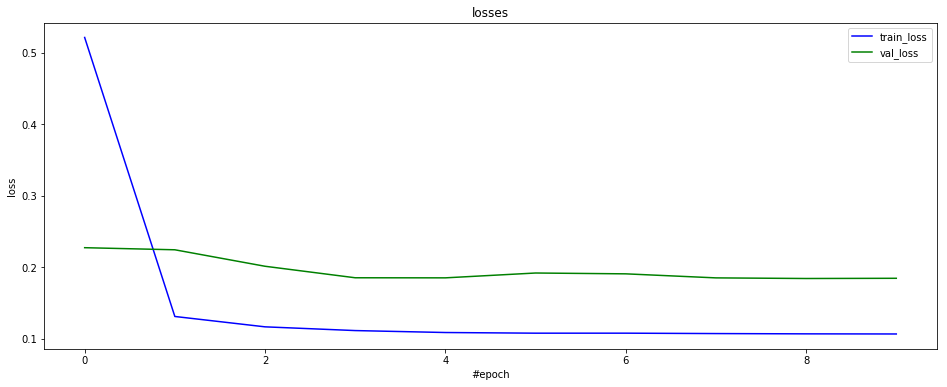

Finished!


In [135]:
generator, epoch_history = train(generator, X_tr, X_te, y_tr, y_te, batchsize=1, n_epochs = 10)

## Save/load the model

In [14]:
from model import Generator, iterate_minibatches, compute_loss, train
torch.save(generator.state_dict(), os.path.join(OUT_DIR, 'model_canonical'))
the_model = Generator()
the_model.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_canonical')))

In [137]:
# print(the_model)
# for i in list(the_model.note_ax.note_lstm.parameters()):
#     print(i.shape)

In [11]:
# dummy_note = Variable(torch.Tensor(train_data[0]))
# chosen = Variable(torch.Tensor(train_data[1]))

# # output = generator.forward(dummy_note, chosen)
# output = the_model.forward(dummy_note, chosen)

# print('dummy_time_features :', output.shape)
# output[0][0][3], output2[0][0][3]

# Canonical

In [136]:
write_file('output/canonical_test', generate(generator, 4))

  0%|          | 0/64 [00:00<?, ?it/s]

Generating with no styles:


100%|██████████| 64/64 [00:46<00:00,  1.38it/s]

Writing file out/samples/output/canonical_test_0.mid


In [138]:
midi_file = 'out/samples/output/canonical_test_0.mid'
play_music(midi_file)

Music file out/samples/output/canonical_test_0.mid loaded!
